# K2-18b JWST Transit Modeling using exoplanet

# Modelovanje tranzita K2-18b pomoću JWST i exoplanet paketa
Ovaj notebook koristi podatke sa Svemirskog teleskopa Džejms Veb (JWST) da bi modelovao svetlosnu krivu tranzita egzoplanete K2-18b. Analiza koristi pakete exoplanet i pymc za izvođenje Bayesove analize tranzitnog modela, sa ciljem da se procene ključni orbitialni i fizički parametri planete.

📥 Ulazni podaci
Svetlosna kriva u beloj svetlosti (white-light curve) za K2-18b, u ECSV (ASCII tabela) formatu.

Podaci uključuju:

Vremenske serije (MJD format),

Normalizovane vrednosti fluksa, i

greške merenja (šum).


📊 Rezultati
Period rotacije planete
kao i grafik:
K2-18b Transit Fit using exoplanet



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import exoplanet as xo
from astropy.table import Table

In [2]:
# Load white-light curve data from the ECSV file
filename = "jw02722-o002_t001_miri_p750l-slitlessprism_whtlt.ecsv"
tbl = Table.read(filename, format="ascii.ecsv")
time = tbl['MJD']
flux = tbl['whitelight_flux']
flux_err = np.ones_like(flux) * np.std(flux[:50])  # crude estimate if error column is missing

# Normalize flux
flux = flux / np.median(flux)

# Shift time to reduce numerical errors
time = time - np.median(time)

In [3]:
# Start PyMC model
with pm.Model() as model:
    # Stellar parameters
    mean = pm.Normal("mean", mu=1.0, sigma=0.1)
    u = xo.distributions.QuadLimbDark("u")

    # Orbital parameters
    period = pm.Normal("period", mu=33.0, sigma=5.0)  # rough guess
    t0 = pm.Normal("t0", mu=0.0, sigma=1.0)
    ror = pm.Uniform("ror", lower=0.01, upper=0.5)  # Rp/Rs
    b = pm.Uniform("b", lower=0, upper=1)
    duration = pm.Normal("duration", mu=0.2, sigma=0.05)

    # Orbit and light curve model
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
    light_curve = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=ror, t=time).flatten()

    # Likelihood
    pm.Normal("obs", mu=mean * (1 + light_curve), sigma=flux_err, observed=flux)

    # Sampling
    map_soln = pm.find_MAP()
    trace = pm.sample(draws=1000, tune=1000, start=map_soln, chains=2, cores=2, target_accept=0.95, return_inferencedata=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9344\2214523189.py:23: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(draws=1000, tune=1000, start=map_soln, chains=2, cores=2, target_accept=0.95, return_inferencedata=True)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mean, __u_q1, __u_q2, period, t0, ror, b, duration]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 878 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [4]:
# Summary
print(az.summary(trace, var_names=["period", "t0", "ror", "b"]))

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
period  32.946  5.000  23.373   41.591      0.143    0.101    1236.0   
t0       0.129  1.092  -1.925    1.941      0.122    0.087      93.0   
ror      0.247  0.140   0.012    0.470      0.004    0.003    1190.0   
b        0.500  0.295   0.000    0.946      0.009    0.006    1165.0   

        ess_tail  r_hat  
period    1336.0   1.00  
t0         606.0   1.01  
ror        789.0   1.00  
b          734.0   1.00  


Sampling: [obs]


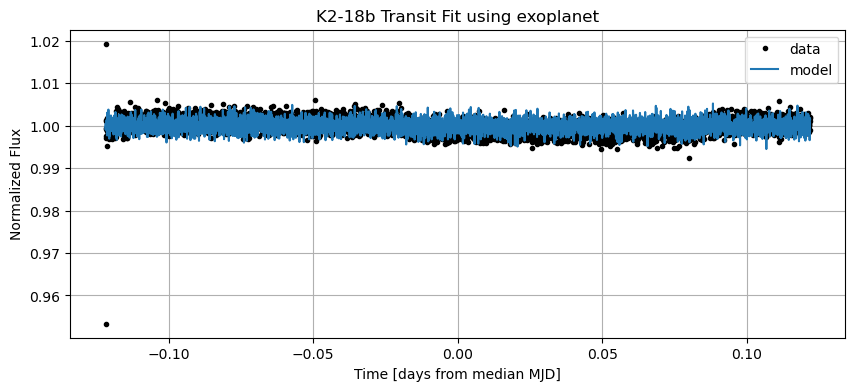

In [5]:
# Plot the fit
with model:
    pred = pm.sample_posterior_predictive(trace, var_names=["obs"])

plt.figure(figsize=(10, 4))
plt.plot(time, flux, ".k", label="data")
plt.plot(time, np.median(pred.posterior_predictive["obs"], axis=(0, 1)), label="model")
plt.xlabel("Time [days from median MJD]")
plt.ylabel("Normalized Flux")
plt.legend()
plt.grid(True)
plt.title("K2-18b Transit Fit using exoplanet")
plt.show()